## <CENTER> The $Z^0$ boson as an example
_____________________________________________

### Using what you have learned so far, let's see if we can find the $Z^0$ boson as an example!
_____________________________________________

In [1]:
# import the ROOT library
import ROOT

Welcome to JupyROOT 6.22/02


### Get the data

There are several data sets from ATLAS that are publicly available, and you can find the latest batch from 2020 at this URL: https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/

Clicking around on the above page, you will find simulated data and real experimental data, in divided into categories based on the final states seen by the ATLAS detector. For this exercise we want to study the Z boson decaying to charged leptons, so we'll look at so-called dilepton events. Navigate into the "2lep" directory, then "data". You will find several files - let's see how we can access these from our code!


In [3]:
# we can load all the files in sequence in a "chain"
# the tree we want to access inside the files is called "mini"
chains = {}
chains["data"] = ROOT.TChain("mini")

# there are several files for the data
chains["data"].Add("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/Data/data_A.2lep.root")
#chain.Add("...") # add more files to the chain here
#chain.Add("...")
#chain.Add("...")

# let's also look at some simulated data - there are lots of processes that can give two leptons 
# listed in the MC dir, but we'll only use Z(ee) and Z(mumu) for now
chains["mc2e"] = ROOT.TChain("mini")
chains["mc2e"].Add("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/mc_361106.Zee.2lep.root")
chains["mc2mu"] = ROOT.TChain("mini")
chains["mc2mu"].Add("https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/2lep/MC/mc_361107.Zmumu.2lep.root")

for s in chains:
    print("Loaded sample %s containing %d events" % (s, chains[s].GetEntries()))

Loaded sample data containing 668152 events
Loaded sample mc2e containing 21848524 events
Loaded sample mc2mu containing 22122816 events


### Helper function for invariant mass

In [4]:
# this function calculates the invariant mass of a two-particle system
def getInvMass(lep1_pt, lep1_eta, lep1_phi, lep2_pt, lep2_eta, lep2_phi):
    ''' Compute the invariant mass using the formula from the Introduction notebook (assume massless particles)'''
    import math
    m2 = 2*lep1_pt*lep2_pt*(math.cosh(lep1_eta-lep2_eta)-math.cos(lep1_phi-lep2_phi))
    return math.sqrt(m2)

### Prepare histograms

In [5]:
# create a histogram for invariant mass

# define the number of bins and axis range
nBins = 150
lowerEdge = 0
upperEdge = 150

# make a python dictionary holding the histograms for each of the samples
massHistos = {}

# loop over the samples to create the histograms and the counters
for sample in chains:
    massHistos[sample+"_ee"] = ROOT.TH1F("InvariantMass_%s_ee" % sample, "; Invariant mass [GeV]; Number of events", nBins, lowerEdge, upperEdge)
    massHistos[sample+"_mumu"] = ROOT.TH1F("InvariantMass_%s_mumu" % sample, "; Invariant mass [GeV]; Number of events", nBins, lowerEdge, upperEdge)
    


### Run the event loop, find electron-positron/muon-antimuon pairs, evaluate the invariant mass, fill histogram(s). You are looking at data-not all events will contain a $Z^0$ boson. What cuts/requirements do you need to apply to filter out $Z^0$ boson candidate events? In the notebook 1 the different variables in the tree are listed.

In [6]:
# clear the histogram, so you don't fill the same events several times if you re-run the loop
for s in massHistos:
    massHistos[s].Reset()

# loop over all of the samples, i.e. both data and the two simulated MC samples
for s in chains:
    # keep track of the number of events processed
    nEvents = 0
    maxEvents = 10000 # stop after this many events, useful during development
    # also keep track of the number of electron-positron and muon-antimuon pairs found
    for event in chains[s]:
        if nEvents > maxEvents:
            break
        # only process events which have exactly two leptons in them, as we expect for Z->ll
        if event.lep_n == 2:
            # skip events with different-flavor lepton pairs
            if event.lep_type[0] != event.lep_type[1]:
                continue
            # also skip events with same-sign leptons, we don't expect that from Z decays
            if event.lep_charge[0] == event.lep_charge[1]:
                continue
            m = getInvMass(event.lep_pt[0], event.lep_eta[0], event.lep_phi[0],
                          event.lep_pt[1], event.lep_eta[1], event.lep_phi[1])
            # fill the right histogram depending on the type of lepton pair found
            if event.lep_type[0] == 11:
                massHistos[s+"_ee"].Fill(m/1000) # divide by 1000 to go from MeV to GeV
            elif event.lep_type[0] == 13:
                massHistos[s+"_mumu"].Fill(m/1000) # divide by 1000 to go from MeV to GeV
            if nEvents % 1000 == 0: # only do a print-out every 1000 events
                print("Processed event %d of %s, filled m = %f" % (nEvents, s, m))
        nEvents += 1

Processed event 0 of data, filled m = 92150.030162
Processed event 1000 of data, filled m = 83789.694825
Processed event 2000 of data, filled m = 82315.365551
Processed event 3000 of data, filled m = 81728.506820
Processed event 4000 of data, filled m = 23894.550562
Processed event 5000 of data, filled m = 89061.837246
Processed event 6000 of data, filled m = 40686.713403
Processed event 7000 of data, filled m = 87908.994413
Processed event 8000 of data, filled m = 97660.506267
Processed event 9000 of data, filled m = 88647.539599
Processed event 10000 of data, filled m = 92721.214498
Processed event 0 of mc2e, filled m = 83241.084941
Processed event 1000 of mc2e, filled m = 92482.032553
Processed event 2000 of mc2e, filled m = 80452.872361
Processed event 3000 of mc2e, filled m = 96520.839646
Processed event 4000 of mc2e, filled m = 73808.429068
Processed event 5000 of mc2e, filled m = 85791.654421
Processed event 6000 of mc2e, filled m = 90805.219731
Processed event 7000 of mc2e, fil

**Note:**: Since it takes a long time to run over all data, only run over a small number of events while developing. Then, when you are satisfied with the method, you can increase the number of events.

### Draw the invariant mass distribution - do you see the $Z^0$ boson peak?

Let's first have a look at the two MC samples, to see if there are any significant differences expected between electrons and muons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Invariant mass ee


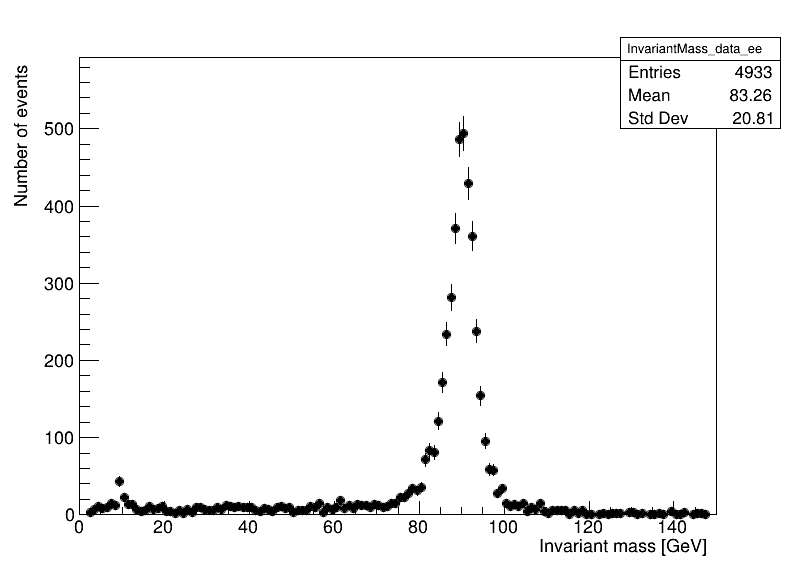

In [9]:
# let's look at the ee case first
eeDataCanvas = ROOT.TCanvas("Invariant mass ee", "Invariant mass ee", 800, 600)

massHistos["data_ee"].SetMarkerStyle(20)
massHistos["data_ee"].SetLineColor(1)
massHistos["data_ee"].Draw() # draw once so that the histogram has axes
# then set the y-axis range
yMax = 1.2*massHistos["data_ee"].GetBinContent(massHistos["data_ee"].GetMaximumBin())
massHistos["data_ee"].GetYaxis().SetRangeUser(0, yMax)
massHistos["data_ee"].Draw("E") # "E" draws data points with simple error bars

eeDataCanvas.Draw()


*** Chi^2 sum = 80.4, N_DoF = 17, ratio = 4.7
 FCN=34.44 FROM MIGRAD    STATUS=CONVERGED     179 CALLS         180 TOTAL
                     EDM=2.25246e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  gamma        5.80784e+00   1.50658e-01   5.82238e-04  -2.95374e-04
   2  mean         9.00462e+01   6.16415e-02   2.51220e-04  -6.38581e-05
   3  norm         4.73661e+03   8.01647e+01   3.10167e-01   4.47852e-07
                               ERR DEF= 0.5


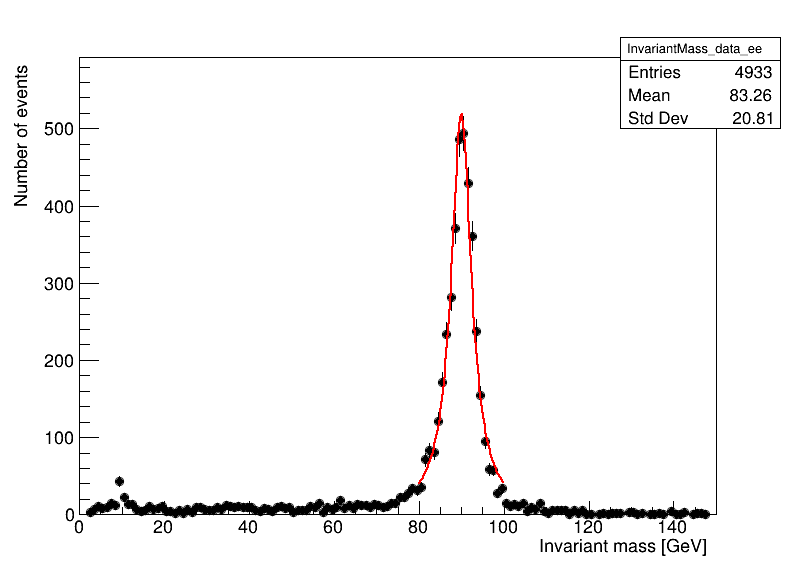

In [10]:
# now let's try to fit a Breit-Wigner curve to the measured invariant mass distribution

# let's define a B-W function with a normalization parameter, and set reasonable starting values
bw = ROOT.TF1("myBreitWigner", "[norm]*TMath::BreitWigner(x, [mean], [gamma])", 80, 100)
bw.SetParameter("norm", 100)
bw.SetParameter("mean", 90)
bw.SetParameter("gamma", 3)

# do the fit
fitResult = massHistos["data_ee"].Fit(bw, "L S", "", 80, 100)
print("\n*** Chi^2 sum = {:.1f}, N_DoF = {}, ratio = {:.1f}".format(fitResult.Chi2(),
                                                                    fitResult.Ndf(),
                                                                    fitResult.Chi2()/fitResult.Ndf()))

# draw the canvas again to see the fit
eeDataCanvas.Draw()

### How good is the fit? Can you improve the it?
Does the measured mass come out near the true value? What does the $\chi^2/N_{DoF}$ say about the fit quality? 

**If you want to get better at the craft of fitting:**
* What can you do to improve the fit? 
* Could adding a (small) additional function that describes the background help? 
* Could something be done to account for the effects from imperfect detector/measurements?

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Invariant mass ee data-MC


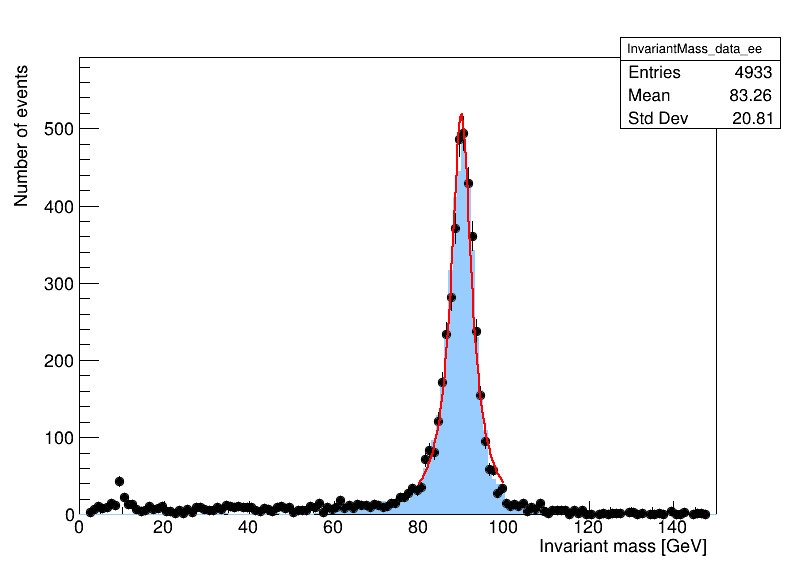

In [12]:
# now let's draw both data and MC so that we can see how well the simulations
# describe the data

# let's look at the ee case first
eeCanvas = ROOT.TCanvas("Invariant mass ee data-MC", "Invariant mass ee data-MC", 800, 600)

yMax = 1.2*massHistos["data_ee"].GetBinContent(massHistos["data_ee"].GetMaximumBin())
massHistos["data_ee"].GetYaxis().SetRangeUser(0, yMax)
massHistos["data_ee"].Draw("E") # "E" draws data points with simple error bars

# scale the MC histogram to the data to more easily compare the shapes
# use the integral around the peak to normalize
maxBinMC = massHistos["mc2e_ee"].GetMaximumBin()
integralMC = massHistos["mc2e_ee"].Integral(maxBinMC-3, maxBinMC+3)
maxBinData = massHistos["data_ee"].GetMaximumBin()
integralData = massHistos["data_ee"].Integral(maxBinData-3, maxBinData+3)
massHistos["mc2e_ee"].Scale(integralData/integralMC)

massHistos["mc2e_ee"].SetLineColor(ROOT.kAzure-9)
massHistos["mc2e_ee"].SetFillColor(ROOT.kAzure-9)
massHistos["mc2e_ee"].Draw("HIST SAME")

massHistos["data_ee"].Draw("SAME E") # draw the data again so that it's on top

eeCanvas.Draw()

In [ ]:
# now do the same for the muon-antimuon pairs!

...

### You're now ready to go hunting for new particles yourself in [4-Explore](4-Explore.ipynb)!